In [1]:
import influxdb
from datetime import datetime
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Connecting to influxDB
HOST = 'influx.linklab.virginia.edu'
PORT = 443
USERNAME = 'sahbf24'
PASSWORD = 'raighee7Ahpheej3eud2sheob7seey7'
DATABASE = 'gateway-generic'

client = influxdb.InfluxDBClient(HOST, PORT, USERNAME, PASSWORD, DATABASE, ssl=True, verify_ssl=True)

In [18]:
query = """
    SELECT SUM("value") / 60000 AS "kWh"
    FROM "power_w"
    WHERE "location_specific" =~ /^([0-9]+ Olsson)$/
    AND time >= now() - 5w
    GROUP BY time(1w), "location_specific" FILL(0)
"""

result = client.query(query)

# put results in df and make column location_specific

rows = []
for (measurement, tags), points in result.items():
    location = tags.get('location_specific', 'Unknown')
    for p in points:
        rows.append({
            'time': pd.to_datetime(p['time']),
            'location_specific': location,
            'energy_kWh': round(p.get('kWh', 0), 2) # Convert kWh to MWh
        })

df = pd.DataFrame(rows)
df.sort_values(['location_specific', 'time'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Add an incremental week counter (starts at 1)
df['week'] = df.groupby('location_specific').cumcount() + 1

df.head(20)


,time,location_specific,energy_kWh,week
0,2025-10-02 00:00:00+00:00,200 Olsson,0.00,1
1,2025-10-09 00:00:00+00:00,200 Olsson,0.00,2
2,2025-10-16 00:00:00+00:00,200 Olsson,0.00,3
3,2025-10-23 00:00:00+00:00,200 Olsson,0.00,4
4,2025-10-30 00:00:00+00:00,200 Olsson,0.08,5
5,2025-11-06 00:00:00+00:00,200 Olsson,-0.00,6
6,2025-10-02 00:00:00+00:00,201 Olsson,144.36,1
7,2025-10-09 00:00:00+00:00,201 Olsson,162.18,2
8,2025-10-16 00:00:00+00:00,201 Olsson,149.68,3
9,2025-10-23 00:00:00+00:00,201 Olsson,214.91,4


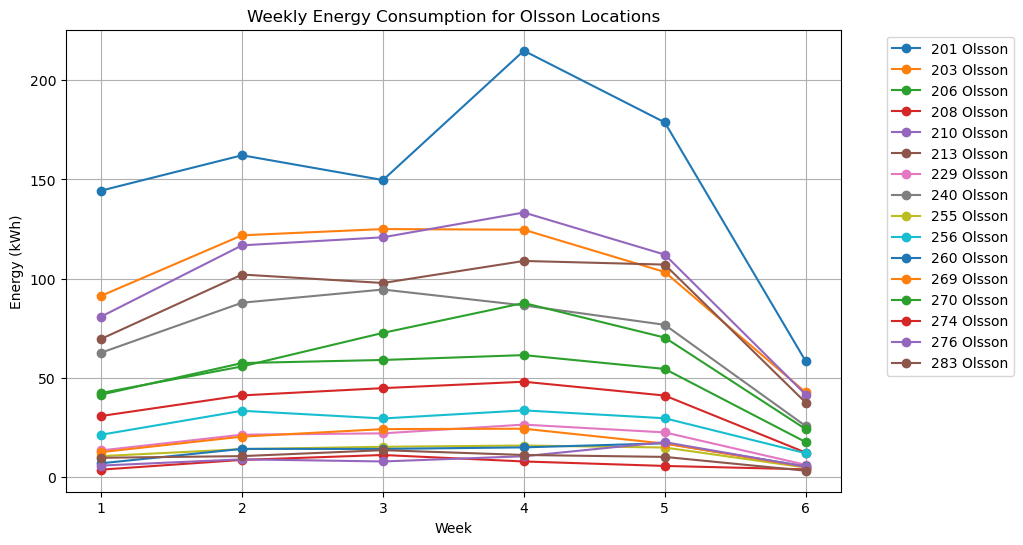

In [26]:
# filter dataset to remove rooms where energy levels are below 10 kWh for all weeks
filtered_df = pd.DataFrame()
for location, group in df.groupby('location_specific'):
    if group['energy_kWh'].max() >= 10:
        filtered_df = pd.concat([filtered_df, group], ignore_index=True)

# graph all locations on one line plot
fig, ax = plt.subplots(figsize=(10, 6))
for location, group in filtered_df.groupby('location_specific'):
    ax.plot(group['week'], group['energy_kWh'], marker='o', label=location)
ax.set_xlabel('Week')
ax.set_ylabel('Energy (kWh)')
ax.set_title('Weekly Energy Consumption for Olsson Locations')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

In [44]:
query = """
    SELECT SUM("value") / 60000 AS "kWh"
    FROM "power_w"
    WHERE "location_specific" =~ /^([0-9]+ Olsson)$/
    AND time >= '2022-01-01T00:00:00Z'
    AND time <= '2025-11-01T00:00:00Z'
    GROUP BY time(1w), "location_specific" FILL(0)
"""

result = client.query(query)

# put results in hist_energy and make column location_specific

rows = []
for (measurement, tags), points in result.items():
    location = tags.get('location_specific', 'Unknown')
    for p in points:
        rows.append({
            'time': pd.to_datetime(p['time']),
            'location_specific': location,
            'energy_kWh': round(p.get('kWh', 0), 2) # Convert kWh to MWh
        })

hist_energy = pd.DataFrame(rows)
hist_energy.sort_values(['location_specific', 'time'], inplace=True)
hist_energy.reset_index(drop=True, inplace=True)

# Add an incremental week counter (starts at 1)
hist_energy['week'] = hist_energy.groupby('location_specific').cumcount() + 1

hist_energy.head(20)

,time,location_specific,energy_kWh,week
0,2021-12-30 00:00:00+00:00,200 Olsson,0.00,1
1,2022-01-06 00:00:00+00:00,200 Olsson,0.00,2
2,2022-01-13 00:00:00+00:00,200 Olsson,0.00,3
3,2022-01-20 00:00:00+00:00,200 Olsson,0.02,4
4,2022-01-27 00:00:00+00:00,200 Olsson,0.20,5
5,2022-02-03 00:00:00+00:00,200 Olsson,0.00,6
6,2022-02-10 00:00:00+00:00,200 Olsson,0.01,7
7,2022-02-17 00:00:00+00:00,200 Olsson,0.13,8
8,2022-02-24 00:00:00+00:00,200 Olsson,0.02,9
9,2022-03-03 00:00:00+00:00,200 Olsson,0.00,10


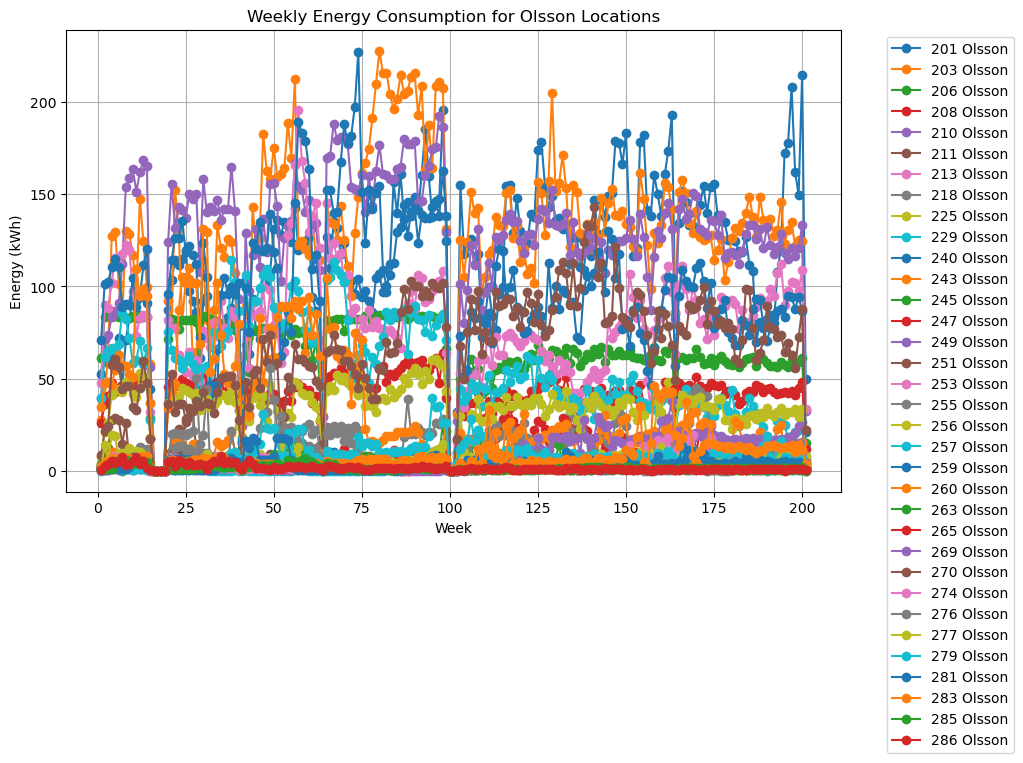

In [50]:
# filter dataset to remove rooms where energy levels are below 10 kWh for all weeks
filtered_hist = pd.DataFrame()
for location, group in hist_energy.groupby('location_specific'):
    if group['energy_kWh'].max() >= 5:
        filtered_hist = pd.concat([filtered_hist, group], ignore_index=True)

# graph all locations on one line plot
fig, ax = plt.subplots(figsize=(10, 6))
for location, group in filtered_hist.groupby('location_specific'):
    ax.plot(group['week'], group['energy_kWh'], marker='o', label=location)
ax.set_xlabel('Week')
ax.set_ylabel('Energy (kWh)')
ax.set_title('Weekly Energy Consumption for Olsson Locations')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

In [51]:
# save unfilitered historical data to csv
hist_energy.to_csv('olsson_historical_energy.csv', index=False)